In [1]:
import pandas as pd
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Index
import shutil
from scipy import stats

%matplotlib inline

sys.stderr.write('Imported required packages.\n')

##
## functions required
##

## read in files
def read_input(filename):
    df = pd.read_csv(filename, sep=None, engine="python")
    return df

# from Momo
class SQLparser:

    def __init__(self,input_blib):
        self._engine = create_engine("sqlite:///%s" % input_blib)

    def get_table_list(self):
        tables = []
        return tables

    def get_table_df(self,table_name):
        meta = MetaData(self._engine,True)
        table_df = None
        if meta.tables.has_key(table_name):
            table_df = pd.read_sql(table_name, self._engine)
        return table_df


class SQLreader:

    def get_peptidescores(self, elibpath):
        sql = SQLparser(elibpath)
        entry_table = sql.get_table_df("peptidescores")  # "peptidescores" database
        selected_column = ["PeptideModSeq", "SourceFile", "IsDecoy"]
        pep_table = entry_table[selected_column]
        pep_table = pep_table[pep_table['IsDecoy'] == False]
        pep_table = pep_table[['PeptideModSeq', 'SourceFile']]

        return pep_table
    
    def get_peptidetoprotein(self, elibpath):
        sql = SQLparser(elibpath)
        entry_table = sql.get_table_df("peptidetoprotein")  # "peptidescores" database
        selected_column = ["PeptideSeq", "ProteinAccession", "isDecoy"]
        selected_table = entry_table[selected_column]
        selected_table = selected_table[selected_table['isDecoy'] == False]
        selected_table = selected_table[['PeptideSeq', 'ProteinAccession']]

        return selected_table
    
    def get_peptidequants(self, elibpath):
        sql = SQLparser(elibpath)
        entry_table = sql.get_table_df("peptidequants")  # "peptidequants" database
        selected_column = ["PeptideSeq", "TotalIntensity"]
        selected_table = entry_table[selected_column]

        return selected_table

sys.stderr.write('Imported required functions.\n')

Imported required packages.
Imported required functions.


<a id = ''></a>
## Data read-in

The input files used here are all available on the Panorama Project https://panoramaweb.org/matrix-matched_calcurves.url

The `elib` file is the EncyclopeDIA output produced by detecting and quantifying peptides in DIA experiments using an on-column DIA-based chromatogram library (explained in more detail by Searle et al, https://doi.org/10.1038/s41467-018-07454-w). 

The LOQ file `figuresofmerit.csv` is the output files of running the proposed calibration curve fitting model to the CSF matrix-matched calibration curve data (yeast diluted in 15N-labeled yeast).

In [5]:
##
## library detections
##

project_dir = "G:/My Drive/00_UW_GS/proj/CalibratedQuant_DIA-MS/"

# map for all detected peptides to their protein taken from Encyclopedia *.elib 
elib_file = os.path.join(project_dir, './data/20170901_CalCurves_LIBRARY_col1.elib')

## convert elib file
sqlreader = SQLreader()
yeast_lib = sqlreader.get_peptidetoprotein(elib_file)
lib_intns = sqlreader.get_peptidequants(elib_file)
lib_intns['TotalIntensity'] = np.log10(lib_intns['TotalIntensity'])

# concatenate the ProteinAccessions
yeast_lib = yeast_lib.groupby('PeptideSeq')['ProteinAccession'].apply(list).reset_index()
yeast_lib = pd.merge(yeast_lib, lib_intns, on='PeptideSeq', how='outer')
yeast_lib.rename(columns={'PeptideSeq':'Peptide', 
                       'ProteinAccession':'ProteinAccession'}, inplace=True)

def unroll_proteingrouping(row):
    #print row
    
    temp = ';'.join(row)
    temp = temp.replace('[', '').replace(']', '')
    
    return temp

yeast_lib['Protein'] = yeast_lib['ProteinAccession'].apply(unroll_proteingrouping)
yeast_lib['yeast_lib'] = 1.0


##
## wide-window detections and calculating CoV
##

yeast_wide = pd.read_table(os.path.join(project_dir, 
                                    "data/20170901_CalCurves_YeastCurve_QUANT.elib.peptides.txt"))

yeast_wide['Peptide'] = yeast_wide.Peptide.apply(lambda x: x.replace('[+57.0214635]','')).tolist()

yeast_wide['mean'] = yeast_wide[['20170901_CalCurves_YeastCurve_A_1ug-ul_BY4741_025.mzML',
                     '20170901_CalCurves_YeastCurve_A_1ug-ul_BY4741_101.mzML',
                     '20170901_CalCurves_YeastCurve_A_1ug-ul_BY4741_166.mzML']].mean(axis=1)

yeast_wide['stdev'] = yeast_wide[['20170901_CalCurves_YeastCurve_A_1ug-ul_BY4741_025.mzML',
                     '20170901_CalCurves_YeastCurve_A_1ug-ul_BY4741_101.mzML',
                     '20170901_CalCurves_YeastCurve_A_1ug-ul_BY4741_166.mzML']].std(axis=1)

yeast_wide['cov'] = yeast_wide['stdev']/yeast_wide['mean']
yeast_wide['wide_detect'] = 1

yeast_all = pd.merge(yeast_lib[['Peptide', 'Protein', 'TotalIntensity', 'yeast_lib']], 
                   yeast_wide[['Peptide', 'wide_detect', 'numFragments', 'cov']], 
                   on='Peptide', how='outer')
yeast_all.fillna(0, inplace=True)
print len(yeast_all)


##
## figures of merit (LLOQ)
##

yeast_loq = pd.read_csv(os.path.join(project_dir, 
                                    "results/figuresofmerit_yeast2std.csv"))
yeast_loq['Peptide'] = yeast_loq.peptide.apply(lambda x: x.replace('[+57.0214635]','')).tolist()
yeast_loq['LOQ'].replace('inf', np.nan, inplace=True)
yeast_loq['valloq'] = yeast_loq['LOQ']
yeast_loq['LOQ'] = np.where(np.isfinite(yeast_loq['LOQ']) & ~np.isnan(yeast_loq['LOQ']), 1.0, 0.0)

yeast_all = pd.merge(yeast_all, yeast_loq[['Peptide', 'LOQ']], on='Peptide', how='outer')
yeast_all.fillna(0, inplace=True)

print len(yeast_all)
yeast_all.head()

C:\Users\Lindsay\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.


32504
32504


,Peptide,Protein,TotalIntensity,yeast_lib,wide_detect,numFragments,cov,LOQ
0,AAAAGAGGAGDSGDAVTK,sp|P38915|SPT8_YEAST,5.788638,1.0,0.0,0.0,0.000000,0.0
1,AAAALAGGKK,sp|P0C0T4|RS25B_YEAST;sp|Q3E792|RS25A_YEAST,6.146467,1.0,1.0,4.0,1.127609,0.0
2,AAADALSDLEIK,sp|P09938|RIR2_YEAST,7.340147,1.0,1.0,5.0,0.011302,1.0
3,AAAEGVANLHLDEATGEMVSK,sp|P15180|SYKC_YEAST,7.591929,1.0,1.0,5.0,0.143613,1.0
4,AAAFLLGEYSSLITDR,sp|P38065|AP2A_YEAST,5.697135,1.0,0.0,0.0,0.000000,0.0


In [7]:
# peptide-level stats
sys.stdout.write("PEPTIDES\n")
sys.stdout.write("Unique peptides in experiment: %d\n" % 
                 (len(yeast_all['Peptide'].drop_duplicates())))
sys.stdout.write("Unique peptides in wide-window: %d\n" % 
                 (len(yeast_all[~np.isnan(yeast_all['numFragments'])]['Peptide'].drop_duplicates())))
sys.stdout.write("Number of peptides with a finite LOQ: %d\n" % 
                 (len(yeast_all[np.isfinite(yeast_all['LOQ']) | ~np.isnan(yeast_all['LOQ'])][['Peptide']].drop_duplicates())) )
sys.stdout.write("Number of peptides with at least 3 fragments: %d\n" % 
                 (len(yeast_all[yeast_all['numFragments'] >= 3][['Peptide']].drop_duplicates())) )
sys.stdout.write("Number of peptides with acceptable CoV <= 0.2: %d\n" % 
                 (len(yeast_all[yeast_all['cov'] < 0.2][['Peptide']].drop_duplicates())) )
sys.stdout.write("Number of peptides with both an acceptable CoV and a finite LOQ: %d\n" %
                (len(yeast_all[(np.isfinite(yeast_all['LOQ']) | ~np.isnan(yeast_all['LOQ'])) & 
                             (yeast_all['cov'] < 0.2)][['Peptide']].drop_duplicates())))
#sys.stdout.write("Number of peptides with both an acceptable CoV and a finite LOQ and unique to a protein: %d\n" %
#                (len(yeast_all[(np.isfinite(yeast_all['LOQ']) | ~np.isnan(yeast_all['LOQ'])) & 
#                             (yeast_all['cov'] < 0.2) & 
#                             (~yeast_all['Protein'].str.contains(";"))][['Peptide']].drop_duplicates())))

# protein-level stats
sys.stdout.write("\nPROTEIN GROUPS\n")
sys.stdout.write("Unique proteins in experiment: %d\n" % 
                 (len(yeast_all['Protein'].drop_duplicates())))
sys.stdout.write("Unique proteins in wide-window: %d\n" % 
                 (len(yeast_all[~np.isnan(yeast_all['numFragments'])]['Protein'].drop_duplicates())))
sys.stdout.write("Number of proteins with at least one peptide with at least 3 fragments: %d\n" % 
                 (len(yeast_all[yeast_all['numFragments'] >= 3][['Protein']].drop_duplicates())) )
sys.stdout.write("Number of proteins with at least one peptide with a finite LOQ: %d\n" % 
                 (len(yeast_all[np.isfinite(yeast_all['LOQ']) | ~np.isnan(yeast_all['LOQ'])][['Protein']].drop_duplicates())) )
sys.stdout.write("Number of proteins with at least one peptide with an acceptable CoV <= 0.2: %d\n" % 
                 (len(yeast_all[yeast_all['cov'] < 0.2][['Protein']].drop_duplicates())) )
sys.stdout.write("Number of proteins with both an acceptable CoV and a finite LOQ: %d\n" %
                (len(yeast_all[(np.isfinite(yeast_all['LOQ']) | ~np.isnan(yeast_all['LOQ'])) & 
                             (yeast_all['cov'] < 0.2)][['Protein']].drop_duplicates())))
sys.stdout.write("Number of proteins with both an acceptable CoV and a finite LOQ and have a unique peptide: %d\n" %
                (len(yeast_all[(yeast_all['LOQ'] == 1.0) & 
                             (yeast_all['cov'] < 0.2) & 
                             (~yeast_all['Protein'].str.contains(";"))][['Protein']].drop_duplicates())))


PEPTIDES
Unique peptides in experiment: 31626
Unique peptides in wide-window: 31626
Number of peptides with a finite LOQ: 31626
Number of peptides with at least 3 fragments: 21116
Number of peptides with acceptable CoV <= 0.2: 16903
Number of peptides with both an acceptable CoV and a finite LOQ: 16903

PROTEIN GROUPS
Unique proteins in experiment: 3437
Unique proteins in wide-window: 3437
Number of proteins with at least one peptide with at least 3 fragments: 2596
Number of proteins with at least one peptide with a finite LOQ: 3437
Number of proteins with at least one peptide with an acceptable CoV <= 0.2: 3145
Number of proteins with both an acceptable CoV and a finite LOQ: 3145


TypeError: bad operand type for unary ~: 'float'

<a id = 'prelim'></a>
## Figure options

In [8]:
plotting_df = yeast_all
plotting_df['wide_detect'] = plotting_df['wide_detect']*plotting_df['TotalIntensity']
plotting_df['frag'] = np.where(plotting_df['numFragments'] > 2, plotting_df['TotalIntensity'], 0)
plotting_df['reprod'] = np.where(plotting_df['cov'] <= 0.2, plotting_df['TotalIntensity'], 0)
plotting_df['acc'] = np.where(plotting_df['LOQ'] > 0, plotting_df['TotalIntensity'], 0)
plotting_df = plotting_df[['Peptide', 'Protein', 'TotalIntensity', 'wide_detect', 'frag', 'reprod', 'acc']]
plotting_df.head()

,Peptide,Protein,TotalIntensity,wide_detect,frag,reprod,acc
0,AAAAGAGGAGDSGDAVTK,sp|P38915|SPT8_YEAST,5.788638,0.000000,0.000000,5.788638,0.000000
1,AAAALAGGKK,sp|P0C0T4|RS25B_YEAST;sp|Q3E792|RS25A_YEAST,6.146467,6.146467,6.146467,0.000000,0.000000
2,AAADALSDLEIK,sp|P09938|RIR2_YEAST,7.340147,7.340147,7.340147,7.340147,7.340147
3,AAAEGVANLHLDEATGEMVSK,sp|P15180|SYKC_YEAST,7.591929,7.591929,7.591929,7.591929,7.591929
4,AAAFLLGEYSSLITDR,sp|P38065|AP2A_YEAST,5.697135,0.000000,0.000000,5.697135,0.000000


[ 3.3239473   5.55631616  5.79090841  5.97692404  6.14646663  6.30949084
  6.48499379  6.68892894  6.94072238  7.31213893  9.39291959]


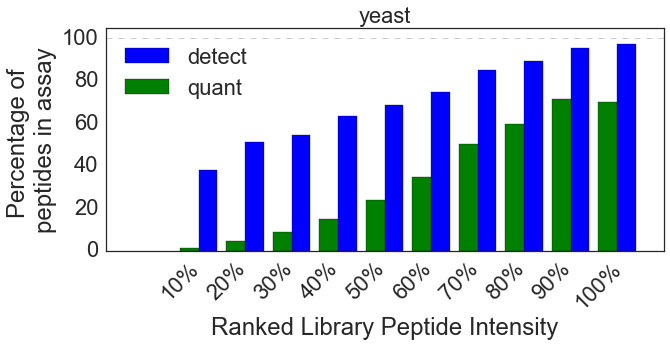

In [9]:
temp = plotting_df[['TotalIntensity','wide_detect','frag','acc']]
temp = temp.replace([np.inf, -np.inf], np.nan).fillna(0)
temp = temp[temp['TotalIntensity'] > 0]

#bins = np.linspace(min(proteincopies_df[proteincopies_df['ghaemma'] > 0]['ghaemma'])-np.finfo(float).eps, 
#                   max(proteincopies_df['ghaemma']), 8).tolist()
#bins.append(1)
#bins.append(6.5)
#bins = np.linspace(min(temp['TotalIntensity']), max(temp['TotalIntensity']), 12).tolist()
#bins = stats.mstats.mquantiles(temp['TotalIntensity'], [0, 1./12, 2./12, 3./12, 4./12, 5./12, 6./12,
#                                                       7./12, 8./12, 9./12, 10./12, 11./12, 1])
bins = np.unique(stats.mstats.mquantiles(temp['TotalIntensity'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10,
                                                       7./10, 8./10, 9./10, 1]))
#bins = pd.qcut(temp['TotalIntensity'], q=12, precision=1)
bins.sort(); print bins

temp['TotalIntensity'] = pd.cut(temp['TotalIntensity'], bins)
temp['wide_detect'] = pd.cut(temp['wide_detect'], bins)
temp['frag'] = pd.cut(temp['frag'], bins)
temp['acc'] = pd.cut(temp['acc'], bins)
#temp.head()

intensity = temp.groupby('TotalIntensity').size() / temp.groupby('TotalIntensity').size() * 100.0
detect = temp.groupby('wide_detect').size() / temp.groupby('TotalIntensity').size() * 100.0
frag = temp.groupby('frag').size() / temp.groupby('TotalIntensity').size() * 100.0
quant = temp.groupby('acc').size() / temp.groupby('TotalIntensity').size() * 100.0

with plt.style.context('seaborn-white'):
    
    SMALL_SIZE = 22
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 26

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    f, ax = plt.subplots(figsize=(10, 4))
    ind = np.array([x for x, _ in enumerate(detect.index)])
    width = 0.4
    #plt.bar(ind, intensity, width, label='TotalIntensity', color='k')
    plt.axhline(100, linewidth=1, linestyle='dashed', alpha=0.2, color='k')
        
    #plt.bar(ind - width, detect, width, label='Detected', color='b')
    plt.bar(ind, detect, width, label='detect', color='b')
    #plt.bar(ind - 0.5*width, frag, width, label='3frag', color='r')
    plt.bar(ind - width, quant, width, label='quant', color='g')

    #plt.xticks(ind - width, list(detect.index), rotation = 90)
    #plt.xticks(ind-width, ['(0-10%]', '(10-20%]', '(20-30%]', '(30-40%]', '(40-50%]', 
    #                       '(50-60%]', '(60-70%]', '(70-80%]', '(80-90%]', '(90-100%]'],
    #          rotation = 45)
    plt.xticks(ind-width, ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], rotation=45)
    plt.ylim(0,105)
    plt.title('yeast')
    plt.ylabel('Percentage of \npeptides in assay')
    plt.xlabel('Ranked Library Peptide Intensity')
    plt.legend(loc='upper left')
    
#plt.savefig('C:/Users/lpino/Desktop/barchart_yeast_peptide.svg', transparent=True, bbox_inches='tight', pad_inches=0.5)